In [53]:
import sys
import stlearn as st
st.settings.set_figure_params(dpi=300)
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sys
file = Path("../stimage").resolve()
parent= file.parent
sys.path.append(str(parent))
from PIL import Image
from stimage._utils import gene_plot, Read10X, ReadOldST, tiling
from stimage._model import CNN_NB_multiple_genes, negative_binomial_layer, negative_binomial_loss
from stimage._data_generator import DataGenerator, DataGenerator_LSTM_one_output
import tensorflow as tf
import seaborn as sns
sns.set_style("white")
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
# import geopandas as gpd
from sklearn.neighbors import KDTree
from anndata import read_h5ad
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
import umap

In [83]:
tf.__version__

'2.4.0'

In [54]:
import skimage
from skimage.color import rgb2hed
from skimage.feature import peak_local_max
from skimage.segmentation import watershed
from skimage.measure import label
import scipy as sp
from scipy import ndimage as ndi
from skimage.morphology import area_opening
import math
from sklearn.linear_model import LinearRegression, SGDRegressor
from lime import lime_image

In [55]:
import matplotlib.pyplot as plt
from libpysal.weights.contiguity import Queen
from libpysal import examples
import numpy as np
import pandas as pd
import geopandas as gpd
import os
import splot
from splot.esda import moran_scatterplot, lisa_cluster
from esda.moran import Moran, Moran_Local
from esda.moran import Moran_BV, Moran_Local_BV
from splot.esda import plot_moran_bv_simulation, plot_moran_bv, plot_local_autocorrelation

In [56]:
import warnings
from typing import Optional, Union
import cv2 as cv
import scanpy
from anndata import AnnData
from matplotlib import pyplot as plt


# from .utils import get_img_from_fig, checkType

from PIL import Image

# from .utils import get_img_from_fig, checkType


def gene_plot(
        adata: AnnData,
        method: str = "CumSum",
        genes: Optional[Union[str, list]] = None,
        threshold: float = None,
        library_id: str = None,
        data_alpha: float = 1.0,
        tissue_alpha: float = 1.0,
        vmin: float = None,
        vmax: float = None,
        cmap: str = "Spectral_r",
        spot_size: Union[float, int] = 6.5,
        show_legend: bool = False,
        show_color_bar: bool = True,
        show_axis: bool = False,
        cropped: bool = True,
        image_scale: int= None,
        margin: int = 100,
        name: str = None,
        output: str = None,
        copy: bool = False,
) -> Optional[AnnData]:
    """\
    Gene expression plot for sptial transcriptomics data.
    Parameters
    ----------
    adata
        Annotated data matrix.
    library_id
        Library id stored in AnnData.
    method
        Use method to count. We prorive: NaiveMean, NaiveSum, CumSum.
    genes
        Choose a gene or a list of genes.
    threshold
        Threshold to filter genes
    data_alpha
        Opacity of the spot.
    tissue_alpha
        Opacity of the tissue.
    cmap
        Color map to use.
    spot_size
        Size of the spot.
    show_color_bar
        Show color bar or not.
    show_axis
        Show axis or not.
    show_legend
        Show legend or not.
    show_trajectory
        Show the spatial trajectory or not. It requires stlearn.spatial.trajectory.pseudotimespace.
    show_subcluster
        Show subcluster or not. It requires stlearn.spatial.trajectory.global_level.
    name
        Name of the output figure file.
    output
        Save the figure as file or not.
    copy
        Return a copy instead of writing to adata.
    Returns
    -------
    Nothing
    """

    # plt.rcParams['figure.dpi'] = dpi

    if type(genes) == str:
        genes = [genes]
    colors = _gene_plot(adata, method, genes)

    if threshold is not None:
        colors = colors[colors > threshold]

    index_filter = colors.index

    filter_obs = adata.obs.loc[index_filter]

    scale_factor = 1
    if image_scale:
        scale_factor = 1 / image_scale

    imagecol = filter_obs["imagecol"] * scale_factor
    imagerow = filter_obs["imagerow"] * scale_factor

    # Option for turning off showing figure
    plt.ioff()

    # Initialize matplotlib
    fig, a = plt.subplots()
    if vmin:
        vmin = vmin
    else:
        vmin = min(colors)
    if vmax:
        vmax = vmax
    else:
        vmax = max(colors)
    # Plot scatter plot based on pixel of spots
    plot = a.scatter(imagecol, imagerow, edgecolor="none", alpha=data_alpha, s=spot_size, marker="o",
                     vmin=vmin, vmax=vmax, cmap=plt.get_cmap(cmap), c=colors)

    if show_color_bar:
        cb = plt.colorbar(plot, cax=fig.add_axes(
            [0.9, 0.3, 0.03, 0.38]), cmap=cmap)
        cb.outline.set_visible(False)

    if not show_axis:
        a.axis('off')

    if library_id is None:
        library_id = list(adata.uns["spatial"].keys())[0]

    image = adata.uns["spatial"][library_id]["images"][adata.uns["spatial"][library_id]["use_quality"]]
    scale_size = (image.shape[1]* scale_factor, image.shape[0]* scale_factor)
    image_pil = Image.fromarray(image)
    image_pil.thumbnail(scale_size, Image.ANTIALIAS)
    image = np.array(image_pil)
    # Overlay the tissue image
    a.imshow(image, alpha=tissue_alpha, zorder=-1, )

    if cropped:
        imagecol = adata.obs["imagecol"] * scale_factor
        imagerow = adata.obs["imagerow"] * scale_factor

        a.set_xlim(imagecol.min() - margin,
                   imagecol.max() + margin)

        a.set_ylim(imagerow.min() - margin,
                   imagerow.max() + margin)

        a.set_ylim(a.get_ylim()[::-1])

    if name is None:
        name = method
    if output is not None:
        fig.savefig(output + "/" + name, dpi=plt.figure().dpi,
                    bbox_inches='tight', pad_inches=0)

    plt.show()


def _gene_plot(adata, method, genes):
    # Gene plot option

    if len(genes) == 0:
        raise ValueError('Genes shoule be provided, please input genes')

    elif len(genes) == 1:

        if genes[0] not in adata.var.index:
            raise ValueError(
                genes[0] + ' is not exist in the data, please try another gene')

        colors = adata[:, genes].to_df().iloc[:, -1]

        return colors
    else:

        for gene in genes:
            if gene not in adata.var.index:
                genes.remove(gene)
                warnings.warn("We removed " + gene +
                              " because they not exist in the data")

            if len(genes) == 0:
                raise ValueError(
                    'All provided genes are not exist in the data')

        count_gene = adata[:, genes].to_df()

        if method is None:
            raise ValueError(
                'Please provide method to combine genes by NaiveMean/NaiveSum/CumSum')

        if method == "NaiveMean":
            present_genes = (count_gene > 0).sum(axis=1) / len(genes)

            count_gene = (count_gene.mean(axis=1)) * present_genes
        elif method == "NaiveSum":
            present_genes = (count_gene > 0).sum(axis=1) / len(genes)

            count_gene = (count_gene.sum(axis=1)) * present_genes

        elif method == "CumSum":
            count_gene = count_gene.cumsum(axis=1).iloc[:, -1]

        colors = count_gene

        return colors

In [57]:
DATA_PATH = Path("/clusterdata/uqxtan9/Xiao/dataset_breast_cancer_9visium")

In [58]:
adata_all = read_h5ad(DATA_PATH / "all_adata.h5ad")
adata_all.obs["tile_path"] = adata_all.obs.tile_path.map(lambda x:x.replace("/clusterdata/uqxtan9/Xiao/breast_cancer_9visium/",
                                               "/clusterdata/uqxtan9/Xiao/dataset_breast_cancer_9visium/"))
gene_list=["IGHG3", "IGHM", "C3", "AP2B1", "GNAS", "PRLR", "PUM1"]
gene_list

['IGHG3', 'IGHM', 'C3', 'AP2B1', 'GNAS', 'PRLR', 'PUM1']

In [59]:
adata_all_train_valid = adata_all[adata_all.obs["library_id"].isin(
    adata_all.obs.library_id.cat.remove_categories(["FFPE", "1160920F"]).unique())]

In [60]:
n_genes = len(gene_list)
training_index = adata_all_train_valid.obs.sample(frac=0.7, random_state=1).index
training_dataset = adata_all_train_valid[training_index,].copy()

valid_index = adata_all_train_valid.obs.index.isin(training_index)
valid_dataset = adata_all_train_valid[~valid_index,].copy()

test_index = adata_all.obs.library_id == "FFPE"
test_dataset_1 = adata_all[test_index,].copy()

test_index = adata_all.obs.library_id == "1160920F"
test_dataset_2 = adata_all[test_index,].copy()

In [61]:
train_gen = tf.data.Dataset.from_generator(
            lambda:DataGenerator(adata=training_dataset, 
                          genes=gene_list, aug=False),
            output_types=(tf.float32, tuple([tf.float32]*n_genes)), 
            output_shapes=([299,299,3], tuple([1]*n_genes))
)
train_gen_ = train_gen.shuffle(buffer_size=500).batch(128).repeat(3).cache().prefetch(tf.data.experimental.AUTOTUNE)
valid_gen = tf.data.Dataset.from_generator(
            lambda:DataGenerator(adata=valid_dataset, 
                          genes=gene_list), 
            output_types=(tf.float32, tuple([tf.float32]*n_genes)), 
            output_shapes=([299,299,3], tuple([1]*n_genes))
)
valid_gen_ = valid_gen.shuffle(buffer_size=500).batch(128).repeat(3).cache().prefetch(tf.data.experimental.AUTOTUNE)
test_gen_1 = tf.data.Dataset.from_generator(
            lambda:DataGenerator(adata=test_dataset_1, 
                          genes=gene_list), 
            output_types=(tf.float32, tuple([tf.float32]*n_genes)), 
            output_shapes=([299,299,3], tuple([1]*n_genes))
)
test_gen__1 = test_gen_1.batch(1)
test_gen_2 = tf.data.Dataset.from_generator(
            lambda:DataGenerator(adata=test_dataset_2, 
                          genes=gene_list), 
            output_types=(tf.float32, tuple([tf.float32]*n_genes)), 
            output_shapes=([299,299,3], tuple([1]*n_genes))
)
test_gen__2 = test_gen_2.batch(1)

In [62]:
# K.clear_session()
# model = CNN_NB_multiple_genes((299, 299, 3), 14)
# callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20,
#                                             restore_best_weights=False)
# model.load_weights("/clusterdata/uqxtan9/Xiao/Q2051/STimage_project/pretrained_model/CNN_NB_9visium_14_markers.h5")

In [63]:
K.clear_session()
model = CNN_NB_multiple_genes((299, 299, 3), n_genes)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20,
                                            restore_best_weights=False)
model.load_weights("/clusterdata/uqxtan9/Xiao/Q2051/STimage_project/pretrained_model/CNN_NB_cancer_immune_7genes.h5")

In [64]:
test_predictions = model.predict(test_gen__1)
from scipy.stats import nbinom
y_preds = []
for i in range(n_genes):
    n = test_predictions[i][:, 0]
    p = test_predictions[i][:, 1]
    y_pred = nbinom.mean(n, p)
    y_preds.append(y_pred)
test_dataset_1.obsm["predicted_gene"] = np.array(y_preds).transpose()

In [1]:
# for i in gene_list:
#     print(i)
#     gene_plot(test_dataset_1, genes=i, spot_size=8, 
#               library_id="FFPE", image_scale=10) 

In [66]:
test_dataset_1_ = test_dataset_1[:,gene_list].copy()
test_dataset_1_.X = test_dataset_1_.obsm["predicted_gene"]

In [2]:
# for i in gene_list:
#     print(i)
#     gene_plot(test_dataset_1_, genes=i, spot_size=8, 
#               library_id="FFPE", image_scale=10) 

In [68]:
def model_predict_gene(gene):
    i = gene_list.index(gene)
    from scipy.stats import nbinom
    def model_predict(x):
        test_predictions = model.predict(x)
        n = test_predictions[i][:, 0]
        p = test_predictions[i][:, 1]
        y_pred = nbinom.mean(n, p)
        return y_pred.reshape(-1,1)
    return model_predict


def watershed_segment(image):
    annotation_hed = rgb2hed(image)
    annotation_h = annotation_hed[:,:,0]
    annotation_h *= 255.0 / np.percentile(annotation_h, q=80)
    thresh = skimage.filters.threshold_otsu(annotation_h)
    im_fgnd_mask = sp.ndimage.morphology.binary_fill_holes(
        annotation_h < thresh
    )
    distance = ndi.distance_transform_edt(im_fgnd_mask)
    coords = peak_local_max(distance, footprint=np.ones((5, 5)), labels=im_fgnd_mask)
    mask = np.zeros(distance.shape, dtype=bool)
    mask[tuple(coords.T)] = True
    markers, _ = ndi.label(mask)
    labels = watershed(annotation_h, markers, mask=im_fgnd_mask)
    im_nuclei_seg_mask = area_opening(labels, area_threshold=64).astype(np.int)
    map_dic = dict(zip(np.unique(im_nuclei_seg_mask), np.arange(len(np.unique(im_nuclei_seg_mask)))))
    im_nuclei_seg_mask = np.vectorize(map_dic.get)(im_nuclei_seg_mask)
    return im_nuclei_seg_mask

In [69]:
explainer = lime_image.LimeImageExplainer()

<ipython-input-68-86082680263d>:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im_nuclei_seg_mask = area_opening(labels, area_threshold=64).astype(np.int)


  0%|          | 0/1000 [00:00<?, ?it/s]

GNAS:
prediction: [1.58761442]
ground truth: [2.1972246]


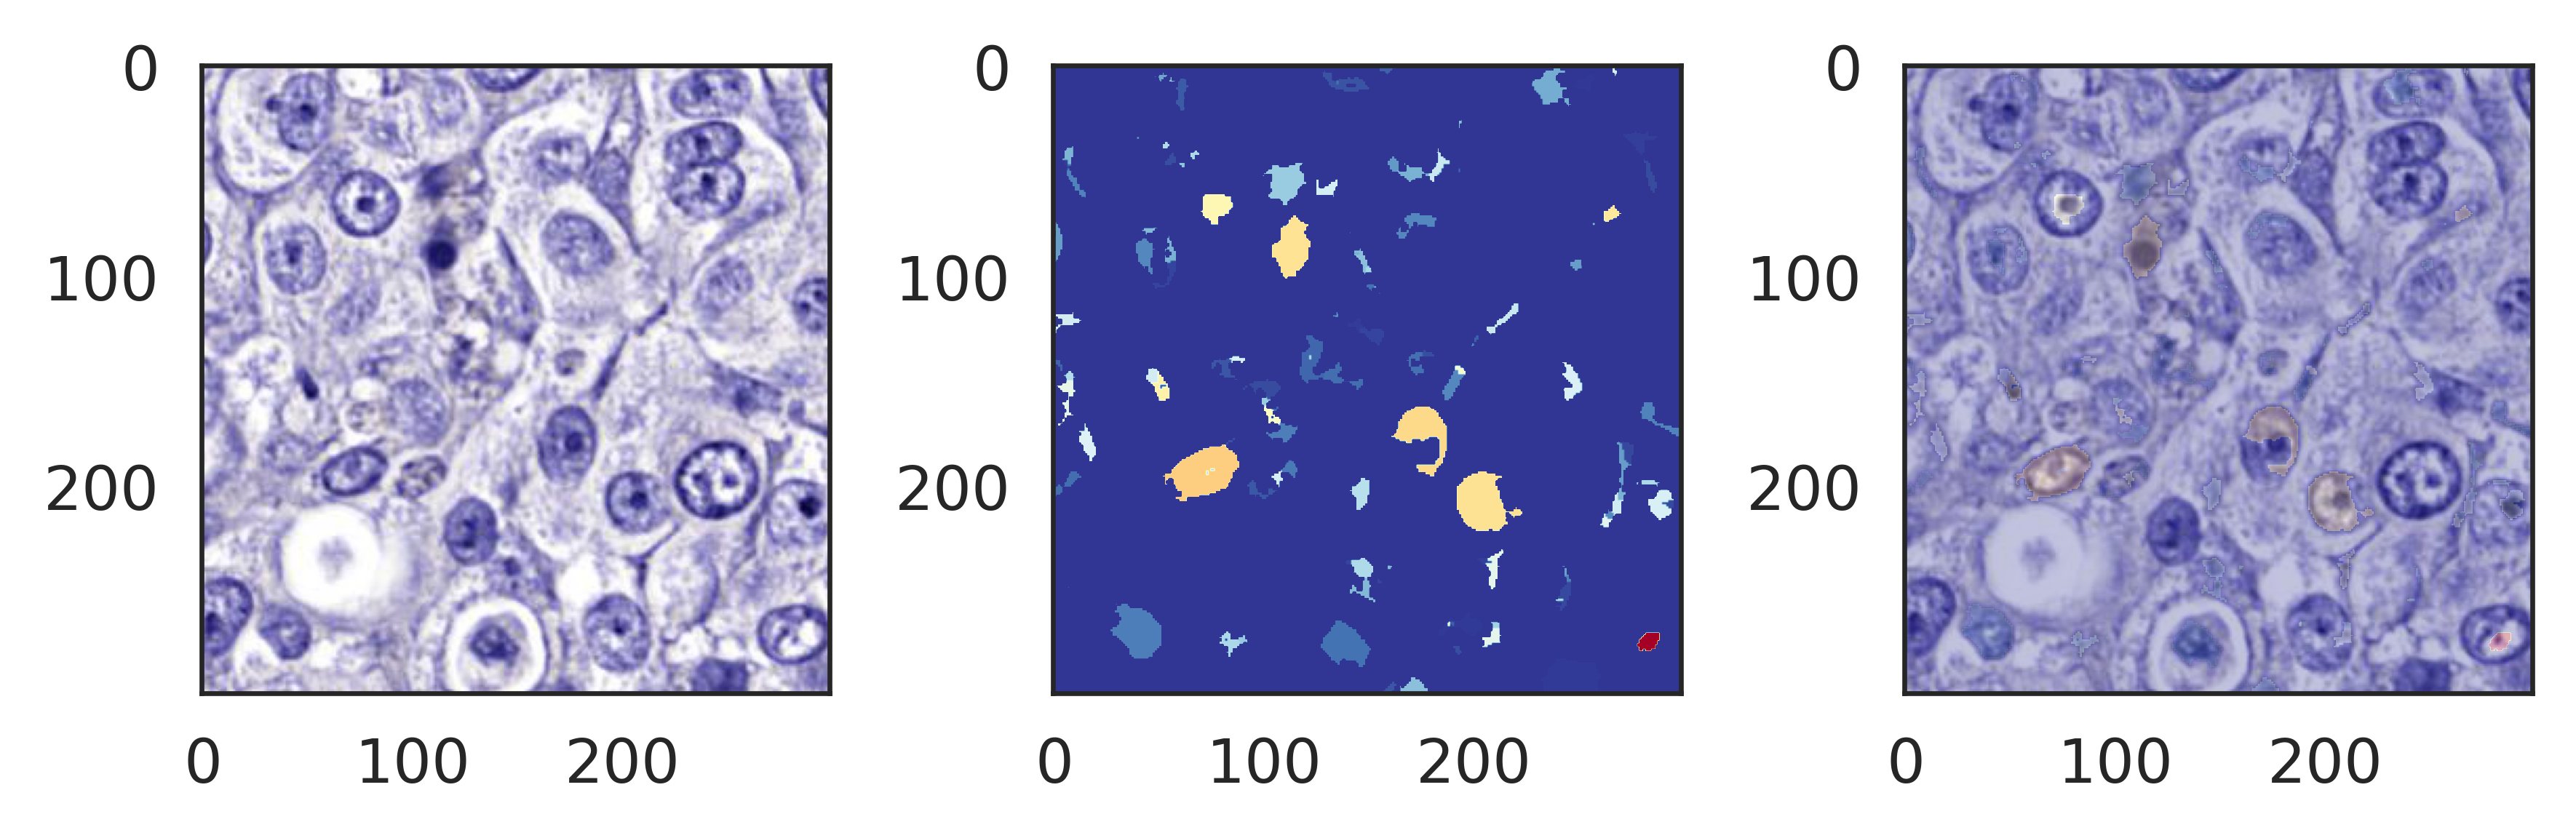

<ipython-input-68-86082680263d>:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im_nuclei_seg_mask = area_opening(labels, area_threshold=64).astype(np.int)


  0%|          | 0/1000 [00:00<?, ?it/s]

IGHM:
prediction: [1.59225702]
ground truth: [1.7917595]


In [70]:
gene_1 = "GNAS"
gene_index_1 = gene_list.index(gene_1)
gene_2 = "IGHM"
gene_index_2 = gene_list.index(gene_2)
for image, label_ in test_gen_1.shuffle(2000).take(1):
    explanation = explainer.explain_instance(image.numpy().astype("float64"), 
                                             model_predict_gene(gene_1), 
                                             top_labels=1, num_samples=1000,
                                             hide_color=0,
#                                              num_features=10000,
#                                              model_regressor=SGDRegressor(),
                                             segmentation_fn=watershed_segment)
    dict_heatmap1 = dict(explanation.local_exp[explanation.top_labels[0]])
    heatmap1 = np.vectorize(dict_heatmap1.get)(explanation.segments)
    prediction = model_predict_gene(gene_1)(np.expand_dims(image.numpy(), 0)).ravel()
    print("{}:".format(gene_1))
    print("prediction: " + str(prediction))
    print("ground truth: " + str(label_[gene_index_1].numpy().ravel()))
    fig = plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().astype(int))
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap1, alpha=1, cmap = 'RdYlBu_r', vmax=1, vmin=0)
    plt.subplot(1, 3, 3)
    plt.imshow(image.numpy().astype(int))
    plt.imshow(heatmap1, alpha=0.3, cmap = 'RdYlBu_r', vmax=1, vmin=0)
    plt.tight_layout()
    plt.show()
    
    explanation = explainer.explain_instance(image.numpy().astype("float64"), 
                                             model_predict_gene(gene_2), 
                                             top_labels=1, num_samples=1000,
                                             hide_color=0,
#                                              num_features=10000,
#                                              model_regressor=SGDRegressor(),
                                             segmentation_fn=watershed_segment)
    dict_heatmap1 = dict(explanation.local_exp[explanation.top_labels[0]])
    heatmap1 = np.vectorize(dict_heatmap1.get)(explanation.segments)
    prediction = model_predict_gene(gene_2)(np.expand_dims(image.numpy(), 0)).ravel()
    print("{}:".format(gene_2))
    print("prediction: " + str(prediction))
    print("ground truth: " + str(label_[gene_index_2].numpy().ravel()))
    fig = plt.figure()
    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().astype(int))
    plt.subplot(1, 3, 2)
    plt.imshow(heatmap1, alpha=1, cmap = 'RdYlBu_r', vmax=1, vmin=0)
    plt.subplot(1, 3, 3)
    plt.imshow(image.numpy().astype(int))
    plt.imshow(heatmap1, alpha=0.3, cmap = 'RdYlBu_r', vmax=1, vmin=0)
    plt.tight_layout()
    plt.show()

In [41]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
tile_input (InputLayer)         [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 305, 305, 3)  0           tile_input[0][0]                 
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 150, 150, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 150, 150, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [74]:
from tensorflow.keras.preprocessing import image as image_fun

In [78]:
image = image_fun.load_img("/clusterdata/uqxtan9/Xiao/Q2051/STimage_project/FFPE-8619-16760-299.jpeg")

In [82]:
explanation = explainer.explain_instance(np.array(image), 
                                             model_predict_gene(gene_1), 
                                             top_labels=1, num_samples=1000,
                                             hide_color=0,
#                                              num_features=10000,
#                                              model_regressor=SGDRegressor(),
                                             segmentation_fn=watershed_segment)
dict_heatmap1 = dict(explanation.local_exp[explanation.top_labels[0]])
heatmap1 = np.vectorize(dict_heatmap1.get)(explanation.segments)
#     prediction = model_predict_gene(gene_1)(np.expand_dims(image.numpy(), 0)).ravel()
#     print("{}:".format(gene_1))
#     print("prediction: " + str(prediction))
#     print("ground truth: " + str(label_[gene_index_1].numpy().ravel()))
#     fig = plt.figure()
plt.subplot(1, 3, 1)
plt.imshow(np.array(image))
plt.subplot(1, 3, 2)
plt.imshow(heatmap1, alpha=1, cmap = 'RdYlBu_r', vmax=1, vmin=0)
plt.subplot(1, 3, 3)
plt.imshow(np.array(image))
plt.imshow(heatmap1, alpha=0.3, cmap = 'RdYlBu_r', vmax=1, vmin=0)
plt.tight_layout()
plt.show()

<ipython-input-68-86082680263d>:27: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im_nuclei_seg_mask = area_opening(labels, area_threshold=64).astype(np.int)


  0%|          | 0/100 [00:00<?, ?it/s]